<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span><ul class="toc-item"><li><span><a href="#Линейная-модель" data-toc-modified-id="Линейная-модель-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Линейная модель</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Dummy" data-toc-modified-id="Dummy-4.0.1"><span class="toc-item-num">4.0.1&nbsp;&nbsp;</span>Dummy</a></span></li></ul></li><li><span><a href="#Линейная-модель" data-toc-modified-id="Линейная-модель-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Линейная модель</a></span></li><li><span><a href="#LGBMRegressor" data-toc-modified-id="LGBMRegressor-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>LGBMRegressor</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#-Комментарий-ревьюера" data-toc-modified-id="-Комментарий-ревьюера-6"><span class="toc-item-num">6&nbsp;&nbsp;</span> Комментарий ревьюера</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [3]:
# подключаем необходимые библиотеки
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.dummy import DummyRegressor
import lightgbm as lgb


import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
# читаем данные
local = False
if local:
    df = pd.read_csv('taxi.csv', parse_dates = [0], index_col = [0])
else:
    url = "https://drive.google.com/file/d/1tuTJTF4SHx17nWkXBvjX8Eccj6lLHrSm/view?usp=sharing"
    path = 'https://drive.google.com/uc?export=download&id='+ url.split('/')[-2]
    df = pd.read_csv(path, parse_dates = [0], index_col = [0])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [7]:
df.head(5)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
# проверяем на монотонность
df.index.is_monotonic

True

In [7]:
# дополнительно проверим на nan
df.isna().sum()

num_orders    0
dtype: int64

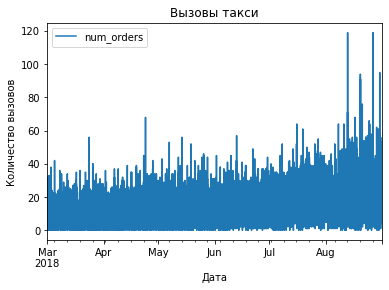

In [8]:
# посмотрим на наш временной ряд
df.plot()
plt.ylabel('Количество вызовов')
plt.xlabel('Дата')
plt.title('Вызовы такси');

In [9]:
# выполним ресемплирование в пределах одного часа
df_resample = df.resample('1H').sum()

In [10]:
df_resample.shape

(4416, 1)

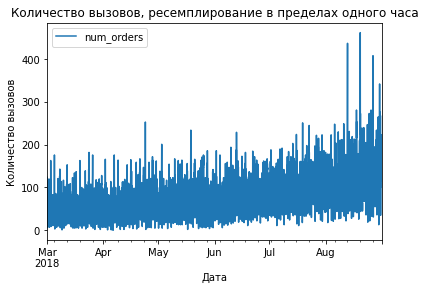

In [11]:
df_resample.plot()
plt.ylabel('Количество вызовов')
plt.xlabel('Дата')
plt.title('Количество вызовов, ресемплирование в пределах одного часа');

После ресэмплирования стал заметен некоторый трэнд по месяцам.

**Вывод:**
- данные успешно загружены
- колонка 'datetime' успешно преобразована к типу дата
- построен индекс по колонке 'datetime'
- данные расположены в порядке возрастания дат без пропусков.

## Анализ

Попробуем декомпозировать датасет.

Во-первых: посмотрим, что происходит по месяцам. 

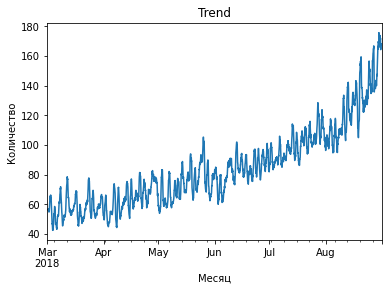

In [12]:
decomposed = seasonal_decompose(df_resample) #, model='additive', freq=1) # < напишите код здесь >
decomposed.trend.plot()
plt.title('Trend')
plt.xlabel('Месяц')
plt.ylabel('Количество');

**Вывод:** Видна явная тенденция к помесячному росту.

Возьмем срез за несколько дней. Например, за май.

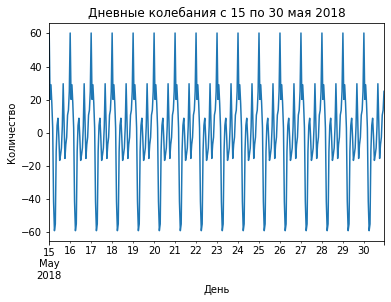

In [13]:
decomposed.seasonal['2018-05-15':'2018-05-30'].plot()
plt.title('Дневные колебания с 15 по 30 мая 2018')
plt.xlabel('День')
plt.ylabel('Количество');

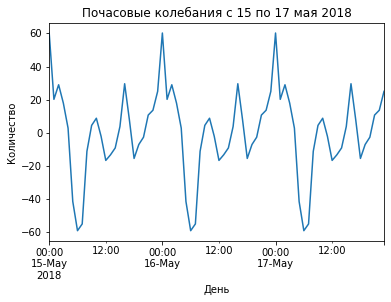

In [14]:
decomposed.seasonal['2018-05-15':'2018-05-17'].plot()
plt.title('Почасовые колебания с 15 по 17 мая 2018')
plt.xlabel('День')
plt.ylabel('Количество');

**Вывод:** Хорошо прослеживаются почасовые колебания целевого признака. Будем использовать данный факт при конструировании признаков.

## Обучение

Добавим в датасет новые признаки. А именно:
- 24 'почасовых' признака с нарастающим лагом запаздывания. 
- месяц, день недели и час в сутках.
- 4 скользящих средних с запаздыванием и усреднением за 6 часов (24/6 = 4)


In [15]:
def make_features(data, max_lag, rolling_mean_size=1):
    data['month'] = data.index.month
#     data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    
    for lag in range(1, 23, 6):
        data['rolling_mean_{}'.format(lag)] = data['num_orders'].shift(lag).rolling(rolling_mean_size).mean()   


In [16]:
df_feature = df_resample.copy()

make_features(df_feature, 24, 6)

df_feature.tail(4)

,num_orders,month,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,...,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,rolling_mean_1,rolling_mean_7,rolling_mean_13,rolling_mean_19
datetime,,,,,,,,,,,,,,,,,,,,,
2018-08-31 20:00:00,154,8,4,20,136.0,207.0,217.0,197.0,116.0,133.0,...,194.0,276.0,246.0,158.0,198.0,142.0,167.666667,174.166667,126.000000,202.333333
2018-08-31 21:00:00,159,8,4,21,154.0,136.0,207.0,217.0,197.0,116.0,...,230.0,194.0,276.0,246.0,158.0,198.0,171.166667,166.000000,118.000000,217.000000
2018-08-31 22:00:00,223,8,4,22,159.0,154.0,136.0,207.0,217.0,197.0,...,99.0,230.0,194.0,276.0,246.0,158.0,178.333333,151.500000,135.333333,200.500000
2018-08-31 23:00:00,205,8,4,23,223.0,159.0,154.0,136.0,207.0,217.0,...,268.0,99.0,230.0,194.0,276.0,246.0,182.666667,152.500000,122.500000,218.833333


Разбиваем новый датасет на тренировочную и тестовую выборки.

In [17]:
train, test = train_test_split(df_feature, shuffle=False, test_size = 0.1)
train = train.dropna()

In [18]:
X_train = train.drop(['num_orders'], axis=1)
y_train = train['num_orders'] 

X_test = test.drop(['num_orders'], axis=1)
y_test = test['num_orders'] 

train.shape

(3950, 32)

### Линейная модель

In [19]:
Lr = LinearRegression()

Для кросс-валидации и подбора параметров воспользуемся поиском на сетке параметров метода **GridSearchCV**. Предварительно разбив обучающую выборку методом **TimeSeriesSplit** для временных рядов. Количество разбиений возьмем равное 6. (По количеству месяцев в датасете)

In [20]:
param_dist = {"normalize": [True, False],"fit_intercept" : [True, False]}                        

my_cv = TimeSeriesSplit(n_splits=6).split(X_train)
grid_search = GridSearchCV(Lr, n_jobs = -1, param_grid = param_dist, cv = my_cv, \
                           scoring = "neg_root_mean_squared_error", verbose = 5)
grid_search.fit(X_train,y_train)

Fitting 6 folds for each of 4 candidates, totalling 24 fits


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001DA280EAE40>,
             estimator=LinearRegression(), n_jobs=-1,
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [21]:
best_estimator_lr = grid_search.best_estimator_

In [22]:
best_params_lr = grid_search.best_params_
best_params_lr

{'fit_intercept': False, 'normalize': True}

In [23]:
grid_search.best_score_

-26.872580722409

### LGBMRegressor

Для корректной работы данной модели выделим категориальные признаки.

In [24]:
cat_features_name = ['month','dayofweek','hour']

for col in cat_features_name:
    X_train[col] = X_train[col].astype('category') 
    X_test[col] = X_test[col].astype('category') 

Обучаем модель на сетке параметров с кросс валидацией

In [25]:
lg = lgb.LGBMRegressor(silent=False)

param_dist = {"max_depth": [50, 100],
               "learning_rate" : [0.1,0.5],
               "boosting_type": ['gbdt','goss','rf'],
               "n_estimators": [200, 500]
}                        

my_cv = TimeSeriesSplit(n_splits = 6).split(X_train)              
            
grid_search = GridSearchCV(lg, n_jobs = -1, param_grid = param_dist, cv = my_cv, \
                           scoring = "neg_root_mean_squared_error", verbose = 5)
grid_search.fit(X_train,y_train)

Fitting 6 folds for each of 24 candidates, totalling 144 fits
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5610
[LightGBM] [Info] Number of data points in the train set: 3950, number of used features: 31
[LightGBM] [Info] Using GOSS
[LightGBM] [Info] Start training from score 78.421013


GridSearchCV(cv=<generator object TimeSeriesSplit.split at 0x000001DA28377190>,
             estimator=LGBMRegressor(silent=False), n_jobs=-1,
             param_grid={'boosting_type': ['gbdt', 'goss', 'rf'],
                         'learning_rate': [0.1, 0.5], 'max_depth': [50, 100],
                         'n_estimators': [200, 500]},
             scoring='neg_root_mean_squared_error', verbose=5)

In [26]:
best_params_lgb = grid_search.best_params_

In [27]:
grid_search.best_score_

-24.896752052017018

In [28]:
best_estimator_lgb = grid_search.best_estimator_

Посмотрим важность признаков.

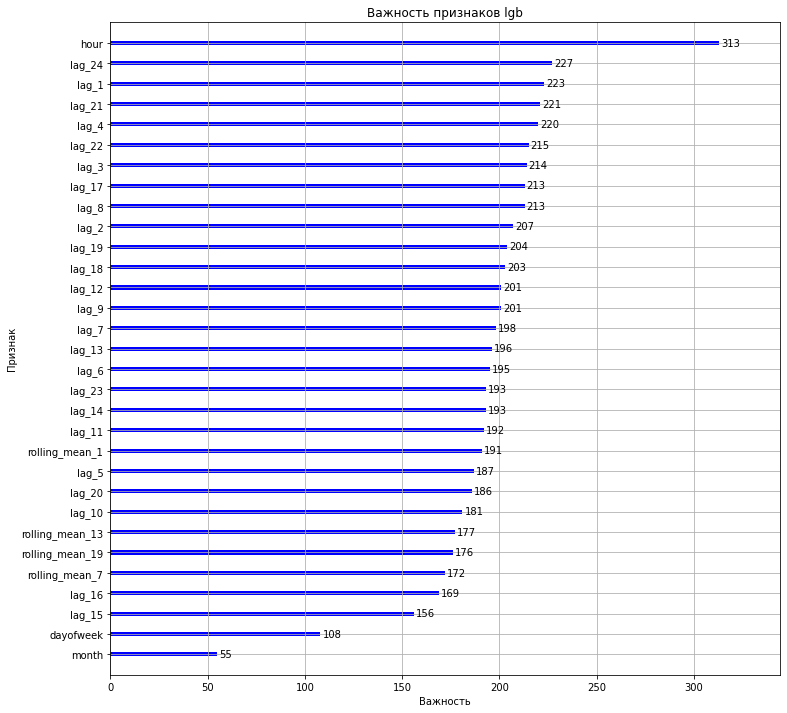

In [29]:
ax0 = lgb.plot_importance(best_estimator_lgb, color='b', title='Важность признаков lgb', xlabel='Важность', \
                          ylabel='Признак', figsize=(12,12))

**Вывод:** Как и ожидалось, самые важные признаки это: собственно час в сутках, плюс его сдвиг в прошлое на 24 часа и на 1 час. Месяц и день недели оказались на последнем месте.

## Тестирование

In [30]:
# список для результатов исследования моделей
result_list=[]

#### Dummy

В качестве отправной точки возьмем константную модель.

In [31]:
model = DummyRegressor(strategy="mean")
model.fit(X_train, y_train)
y_predict = model.predict(X_test)
RMSE = np.sqrt(mean_squared_error(y_test, y_predict))
result_list.append({'model': 'Dummy','RMSE':RMSE})

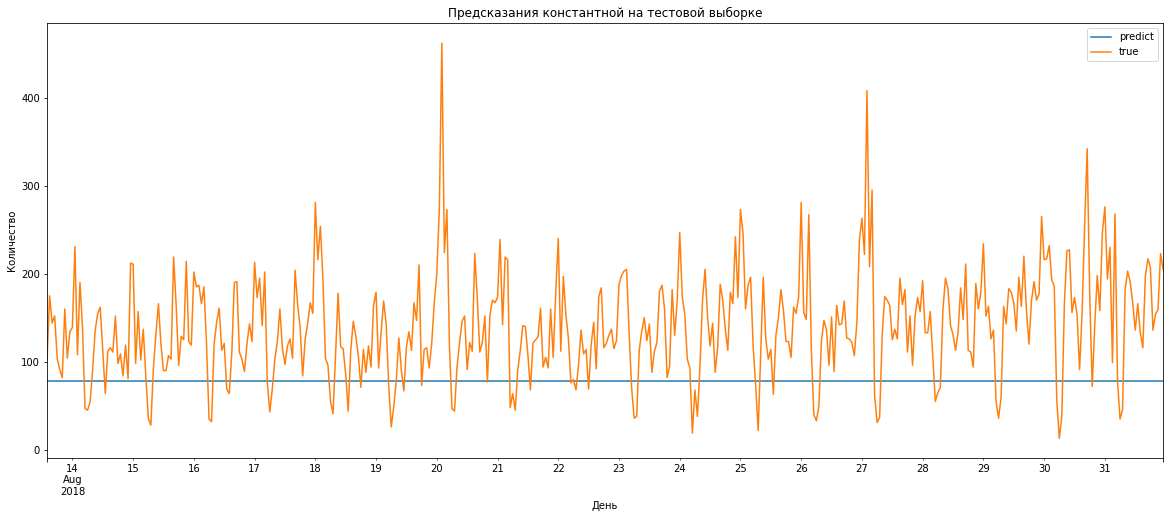

In [32]:
result = pd.DataFrame({'predict':y_predict, 'true':y_test})
result.plot(figsize=(20,8))
plt.title('Предсказания константной на тестовой выборке')
plt.xlabel('День')
plt.ylabel('Количество');

### Линейная модель

In [33]:
y_predict = best_estimator_lr.predict(X_test)

In [34]:
RMSE = np.sqrt(mean_squared_error(y_test, y_predict))
result_list.append({'model': 'LinearRegression','RMSE':RMSE})

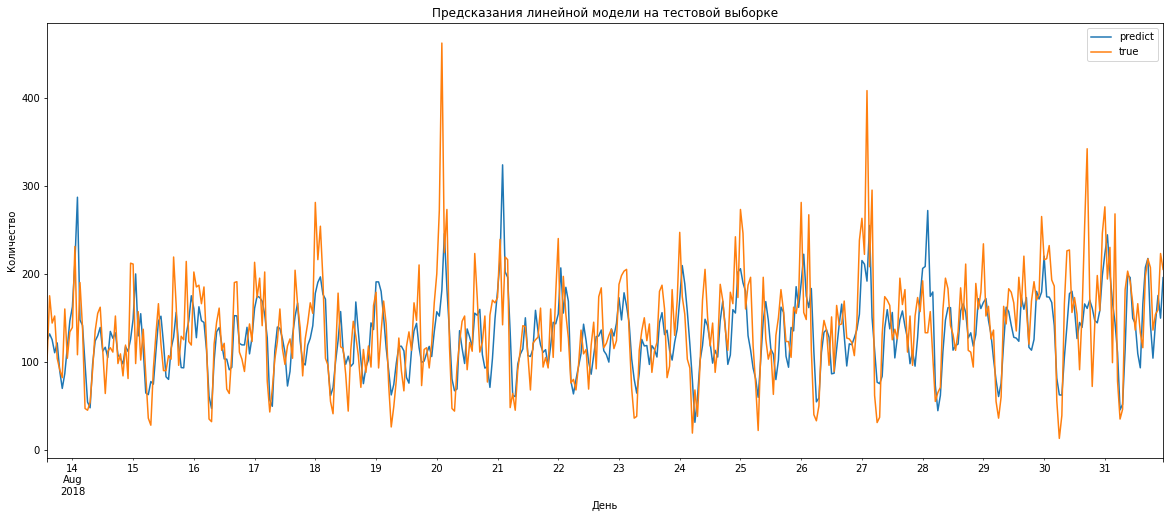

In [35]:
result = pd.DataFrame({'predict':y_predict, 'true':y_test})
result.plot(figsize=(20,8))
plt.title('Предсказания линейной модели на тестовой выборке')
plt.xlabel('День')
plt.ylabel('Количество');

### LGBMRegressor

In [36]:
y_predict = best_estimator_lgb.predict(X_test)

In [37]:
RMSE = np.sqrt(mean_squared_error(y_test, y_predict))
result_list.append({'model': 'LGBMRegressor','RMSE':RMSE})

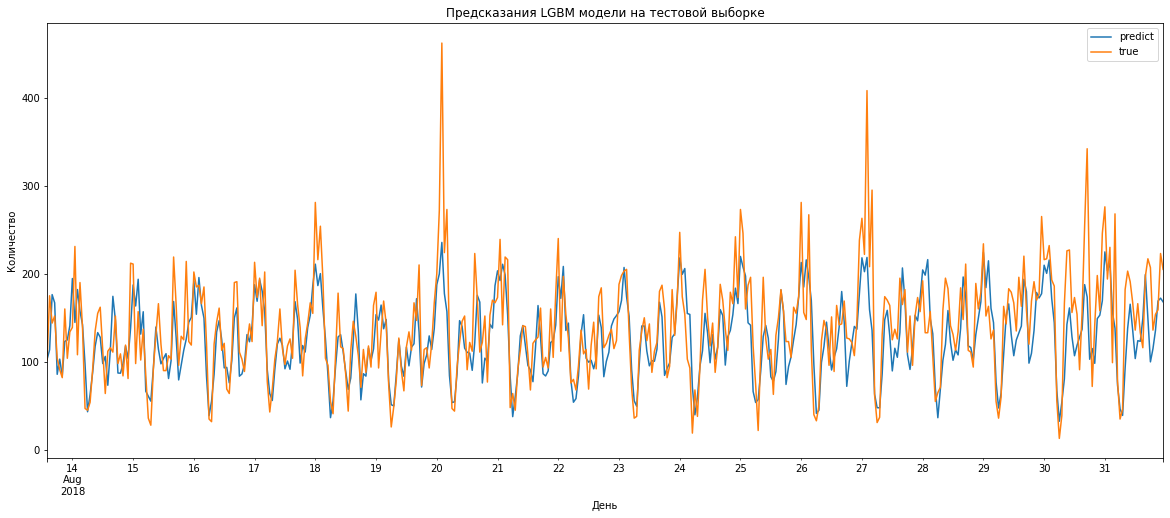

In [38]:
result = pd.DataFrame({'predict':y_predict, 'true':y_test})
result.plot(figsize=(20,8))
plt.title('Предсказания LGBM модели на тестовой выборке')
plt.xlabel('День')
plt.ylabel('Количество');

На графиках видно, что линейная модель и LGBM модель работает приемлимо, если исключить некоторые шумовые выбросы.

Соберем результаты исследования в табличку.

In [39]:
df_result = pd.DataFrame(result_list)
df_result.sort_values(by = 'RMSE')

,model,RMSE
2,LGBMRegressor,39.549023
1,LinearRegression,45.696153
0,Dummy,84.649938


## Выводы

Для прогнозированиия почасового количества заказов такси был проанализирован предложенный датасет. 

Выяснилось, что имеется постоянно растущий помесячный тренд увеличения количества заказов. Кроме того, на графиках отчетливо видны почасовые колебания так называемого 'сезонного' трэнда.

Поэтому, было принято решения добавить дополнительные признаки с почасовым лагом. Всего 24 штуки по количеству часов в сутках. А также, был добавлен порядковый номер месяца в году с целью 'отловить' помесячный рост. И признак 'hour' - час в сутках.

Были построены модель линейной регрессии и модель бустинга LGBMRegressor. Проведена кросс валидация с подбором параметров на сетке для каждой модели.

Для LGBMRegressor была оценена важность построенных признаков. Наиболее важным оказался признак -'hour'. Что, и ожидалось для модели почасового прогнозирования.

Затем, была оценена адекватность моделей путем сравнения метрики RMSE с константной моделью Dummy.

Результаты расчета метрики RMSE представлены в итоговой таблице.

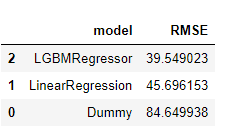

**Итого:** И на модели LGBMRegressor и на модели LinearRegression удалось превзойти заданный порог по метрике RMSE = 48. Адекватность моделей доказана.